In [34]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [35]:
train = pd.read_csv("Train.csv")
valid = pd.read_csv("Valid.csv")

In [36]:
train.head(2)

,Relapse,CEA_Post,Lymphatic,Vascular,pStage,pT,pN,Perineural,Age
0,0,0.0,0,0,4,2,2,0,73
1,0,1.2,1,0,4,2,2,1,73


In [37]:
train['pN'].unique()

array([2, 3, 1], dtype=int64)

In [38]:
(train.corr() > 0.7) # 다중공선성 비교 pStage랑 pN 중 pN 사용

,Relapse,CEA_Post,Lymphatic,Vascular,pStage,pT,pN,Perineural,Age
Relapse,True,False,False,False,False,False,False,False,False
CEA_Post,False,True,False,False,False,False,False,False,False
Lymphatic,False,False,True,False,False,False,False,False,False
Vascular,False,False,False,True,False,False,False,False,False
pStage,False,False,False,False,True,False,True,False,False
pT,False,False,False,False,False,True,False,False,False
pN,False,False,False,False,True,False,True,False,False
Perineural,False,False,False,False,False,False,False,True,False
Age,False,False,False,False,False,False,False,False,True


In [39]:
train.corr() # Lymphatic, Vascular, pN 독립변수로 사용

,Relapse,CEA_Post,Lymphatic,Vascular,pStage,pT,pN,Perineural,Age
Relapse,1.000000,0.163411,0.206385,0.208355,0.180064,0.056499,0.204281,0.130624,-0.001398
CEA_Post,0.163411,1.000000,0.069175,0.056759,0.121155,-0.050621,0.165132,0.201012,-0.000181
Lymphatic,0.206385,0.069175,1.000000,0.228239,0.199909,-0.093983,0.319781,0.160543,-0.076858
Vascular,0.208355,0.056759,0.228239,1.000000,0.129301,0.042075,0.182302,0.250198,0.103310
pStage,0.180064,0.121155,0.199909,0.129301,1.000000,0.370512,0.770096,0.023054,0.099237
pT,0.056499,-0.050621,-0.093983,0.042075,0.370512,1.000000,-0.172943,0.014330,0.166362
pN,0.204281,0.165132,0.319781,0.182302,0.770096,-0.172943,1.000000,0.055978,-0.029191
Perineural,0.130624,0.201012,0.160543,0.250198,0.023054,0.014330,0.055978,1.000000,0.040122
Age,-0.001398,-0.000181,-0.076858,0.103310,0.099237,0.166362,-0.029191,0.040122,1.000000


In [53]:
x_train = train.loc[:, ['Lymphatic', 'Vascular', 'pN']]
y_train = train.loc[:, 'Relapse']
x_valid = valid.loc[:, ['Lymphatic', 'Vascular', 'pN']]
y_valid = valid.loc[:, 'Relapse']

In [47]:
x_train.head(2)

,Lymphatic,Vascular,pN
0,0,0,2
1,1,0,2


In [78]:
model = Sequential()

In [79]:
model.add(Dense(10, activation="linear", input_shape=(3,)))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [80]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 10)                40        
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [81]:
# callback
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='./4-1_model/-{epoch:03d}-{loss:.4f}-{accuracy:.4f}.hdf5',
            monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# 
# Learning Rate 줄여나가기
# patience=3 loss값이 3번연속 떨어질시? factor=0.8 러닝레이트에 0.8을 곱해서 더 느리게 적용하게
LR = ReduceLROnPlateau(monitor='loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [82]:
model.fit(x=x_train, y=y_train, batch_size=32, shuffle=True, epochs=100, 
          validation_data=(x_valid, y_valid), callbacks=CALLBACK)

Epoch 1/100
 1/13 [=>............................] - ETA: 2s - loss: 0.6442 - accuracy: 0.7500
Epoch 1: val_loss improved from inf to 0.69323, saving model to ./4-1_model\-001-0.7016-0.5714.hdf5
13/13 [==============================] - 0s 9ms/step - loss: 0.7016 - accuracy: 0.5714 - val_loss: 0.6932 - val_accuracy: 0.5714 - lr: 0.0100
Epoch 2/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6845 - accuracy: 0.5625
Epoch 2: val_loss improved from 0.69323 to 0.65559, saving model to ./4-1_model\-002-0.6810-0.5944.hdf5
13/13 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5944 - val_loss: 0.6556 - val_accuracy: 0.6429 - lr: 0.0100
Epoch 3/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6973 - accuracy: 0.6250
Epoch 3: val_loss improved from 0.65559 to 0.65167, saving model to ./4-1_model\-003-0.6743-0.5867.hdf5
13/13 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5867 - val_loss: 0.6517 - val_accuracy: 0

 1/13 [=>............................] - ETA: 0s - loss: 0.5276 - accuracy: 0.7812
Epoch 27: val_loss did not improve from 0.63662
13/13 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.6454 - val_loss: 0.6394 - val_accuracy: 0.6429 - lr: 0.0051
Epoch 28/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5512 - accuracy: 0.7812
Epoch 28: val_loss did not improve from 0.63662
13/13 [==============================] - 0s 2ms/step - loss: 0.6382 - accuracy: 0.6429 - val_loss: 0.6426 - val_accuracy: 0.6429 - lr: 0.0051
Epoch 29/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5877 - accuracy: 0.7188
Epoch 29: val_loss did not improve from 0.63662
13/13 [==============================] - 0s 2ms/step - loss: 0.6370 - accuracy: 0.6327 - val_loss: 0.6482 - val_accuracy: 0.6020 - lr: 0.0051
Epoch 30/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6735 - accuracy: 0.5938
Epoch 30: val_loss did not improve from 0.63662

Epoch 30: 

Epoch 54/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6307 - accuracy: 0.5938
Epoch 54: val_loss did not improve from 0.63662

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0008589933626353742.
13/13 [==============================] - 0s 2ms/step - loss: 0.6368 - accuracy: 0.6378 - val_loss: 0.6454 - val_accuracy: 0.6429 - lr: 0.0011
Epoch 55/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5732 - accuracy: 0.7188
Epoch 55: val_loss did not improve from 0.63662
13/13 [==============================] - 0s 2ms/step - loss: 0.6365 - accuracy: 0.6429 - val_loss: 0.6451 - val_accuracy: 0.6429 - lr: 8.5899e-04
Epoch 56/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6599 - accuracy: 0.6250
Epoch 56: val_loss did not improve from 0.63662
13/13 [==============================] - 0s 2ms/step - loss: 0.6363 - accuracy: 0.6429 - val_loss: 0.6449 - val_accuracy: 0.6429 - lr: 8.5899e-04
Epoch 57/100
 1/13 [=>............................] - ET

Epoch 80/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6223 - accuracy: 0.6250
Epoch 80: val_loss did not improve from 0.63662
13/13 [==============================] - 0s 2ms/step - loss: 0.6360 - accuracy: 0.6429 - val_loss: 0.6433 - val_accuracy: 0.6429 - lr: 1.4412e-04
Epoch 81/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6329 - accuracy: 0.6562
Epoch 81: val_loss did not improve from 0.63662

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.00011529214680194855.
13/13 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6429 - val_loss: 0.6433 - val_accuracy: 0.6429 - lr: 1.4412e-04
Epoch 82/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6477 - accuracy: 0.5938
Epoch 82: val_loss did not improve from 0.63662
13/13 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.6429 - val_loss: 0.6433 - val_accuracy: 0.6429 - lr: 1.1529e-04
Epoch 83/100
 1/13 [=>............................]

In [83]:
model.load_weights("./4-1_model/-011-0.6516-0.5918.hdf5")

In [84]:
model.predict(x_valid)

array([[0.39807466],
       [0.3643803 ],
       [0.39807466],
       [0.24913564],
       [0.5240652 ],
       [0.48835883],
       [0.24913564],
       [0.5240652 ],
       [0.48835883],
       [0.48835883],
       [0.48835883],
       [0.48835883],
       [0.48835883],
       [0.48835883],
       [0.48835883],
       [0.48835883],
       [0.27681434],
       [0.39807466],
       [0.24913564],
       [0.30631357],
       [0.24913564],
       [0.24913564],
       [0.24913564],
       [0.35585552],
       [0.45277086],
       [0.3643803 ],
       [0.35585552],
       [0.33196512],
       [0.35585552],
       [0.39807466],
       [0.24913564],
       [0.24913564],
       [0.48835883],
       [0.27681434],
       [0.48835883],
       [0.5240652 ],
       [0.33196512],
       [0.27681434],
       [0.27681434],
       [0.5240652 ],
       [0.27681434],
       [0.3643803 ],
       [0.5240652 ],
       [0.48835883],
       [0.48835883],
       [0.24913564],
       [0.33196512],
       [0.249

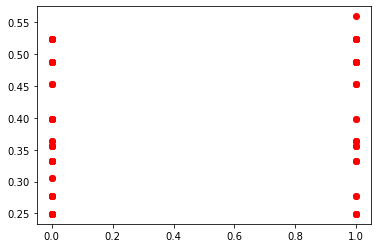

In [90]:
plt.plot(y_valid, model.predict(x_valid), 'ro')
plt.show()

In [91]:
import seaborn as sns

In [98]:
y_valid

0     0
1     1
2     1
3     1
4     0
     ..
93    0
94    1
95    0
96    0
97    0
Name: Relapse, Length: 98, dtype: int64

In [99]:
FinalPrediction = pd.DataFrame({
    'Label': y_valid,
    'Prediction': model.predict(x_valid)[:,0]
})

<AxesSubplot:xlabel='Label', ylabel='Prediction'>

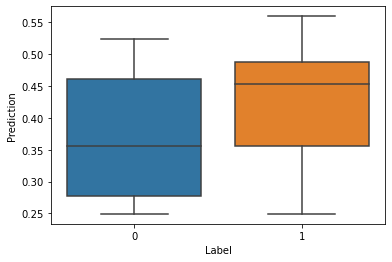

In [100]:
sns.boxplot(data=FinalPrediction, x='Label', y='Prediction')

In [86]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score

In [87]:
print(roc_auc_score(y_valid, model.predict(x_valid)))

0.6462719298245614


In [88]:
from sklearn import metrics
# ROC curve 시각화
Labels = y_valid
pred = model.predict(x_valid)
fpr, tpr, _ = metrics.roc_curve(y_valid,  pred)

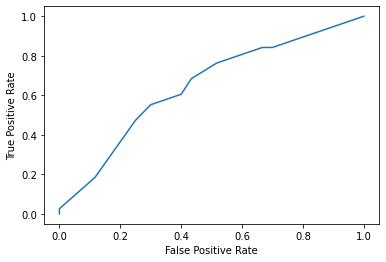

In [89]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

예시
# Call-back 함수 validation에 setting 하는 방법
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='-{epoch:03d}-{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}.hdf5',
            monitor='loss', verbose=1, save_best_only=True, mode='min')
#minitor -> loss -> val_loss
# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3,
                       verbose=1, min_lr=1e-8)
# factor: Learning rate에 곱할 것.
#0.1 -> 0.08 -> 0.064 ....
#monitor='loss' -> monitor='val_loss'
CALLBACK = [CP, LR]

######## Validation을 fit에 추가
model.fit(x=InputFeature, y=Label, epochs=300, shuffle=True)
###validation_data=(x_val, y_val))